## Requests of areas at different scales

### Imports

In [1]:
%matplotlib inline

# Utilities
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
import tempfile
import numpy as np
from pathlib import Path
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape


# Sentinel Hub
from sentinelhub import (
    CRS,    
    ByocTile,
    SentinelHubBYOC,
    BBox,
    bbox_to_dimensions,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
    SHConfig
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

### Import additional packages

In [2]:
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

### Set up credentials

In [4]:
# Insert your credentials here in case you don't already have them in config.json file:
#SH_CLIENT_ID = ""
#SH_CLIENT_SECRET = ""
#AWS_ACCESS_KEY_ID = "949889f6486042289b27d963993d6ef1"
#AWS_SECRET_ACCESS_KEY = "e36838359a09449293136074209f66f1"

config = SHConfig()
sh_client_id = config.sh_client_id 
sh_client_secret = config.sh_client_secret 
aws_access_key_id = config.aws_access_key_id 
aws_secret_access_key = config.aws_secret_access_key 


#if SH_CLIENT_ID and SH_CLIENT_SECRET:
 #   config.sh_client_id = SH_CLIENT_ID
  #  config.sh_client_secret = SH_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Sentinel Hub ASYNC API, please provide the credentials (client ID and client secret).")

if not config.aws_access_key_id or not config.aws_secret_access_key:
    print("Warning! To use AWS services,please provide the credentials (access key id and secret access key).")

### Example Request with Process API

We will download data from Landsat 9

In [ ]:
bbox = (-3.49,54.83,-2.97, 55.04) 

When the bounding box bounds have been defined, you can initialize the BBox of the area of interest. Using the bbox_to_dimensions utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [ ]:
resolution = 20
bbox_wgs84 = BBox(bbox=bbox, crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox_wgs84, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L2,
            time_interval=("2022-03-01", "2022-03-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox_wgs84,
    size=bbox_size,
    config=config,
)

In [ ]:
true_color_imgs = request_true_color.get_data()
image = true_color_imgs[0]
# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=4.5 / 255, clip_range=(0, 1))


### Example Request with Asynchronous Processing API

Asynchronous Processing API is currently in beta release. Asynchronous Processing API (or shortly "Async API") allows you to process more data with a single request than Processing API (maximum output image size cannot exceed 10000 pixels). This is possible because the processing results are not returned immediately but are - after some time - delivered in your object storage. We recommend using Async API when you want to process bigger images, when you do not want to deal with tiled results and when it is not crucial for you to get the processing results immediately.

#### Imports

In addition to the previous libraries, a [requests-oauthlib](https://github.com/requests/requests-oauthlib) library is required to handle the retrieval of access tokens using your OAuth Client configuration.

In [ ]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [ ]:
# Create a session
client = BackendApplicationClient(client_id=sh_client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_secret=sh_client_secret)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

#### Create an asynchronous processing request

In [ ]:
url = 'https://services.sentinel-hub.com/api/v1/async/process'

evalscript = """
//VERSION=3

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08"
      ]
    }],
    output: {
      bands: 3
    }
  }
}

let viz = ColorGradientVisualizer.createWhiteGreen();

function evaluatePixel(samples) {
    let ndvi = index(samples.B08, samples.B04);
    vizualizedNdvi = viz.process(ndvi);
    return vizualizedNdvi;
}

"""

payload = {
  "input" : {
    "bounds" : {
      "bbox" : [ 426000, 3960000, 462000, 3994000 ],
      "properties" : {
        "crs" : "http://www.opengis.net/def/crs/EPSG/0/32633"
      }
    },
    "data" : [ {
      "dataFilter" : {
        "timeRange" : {
          "from" : "2022-06-20T00:00:00Z",
          "to" : "2022-06-30T23:59:59Z"
        }
      },
      "type" : "S2L2A"
    } ]
  },
  "output" : {
    "resx" : 10,
    "resy" : 10,
    "responses" : [ {
      "identifier" : "default",
      "format" : {
        "type" : "image/tiff"
      }
    } ],
    "delivery" : {
      "s3" : {
        "url": "s3://async-request-example/example1/",
        "accessKey": aws_access_key_id,
        "secretAccessKey": aws_secret_access_key     
        }
    }
  },
  "evalscript" : evalscript
}

headers = {
  'Content-Type': 'application/json'
}

response = oauth.post(url, headers=headers, json=payload)
response.json()

In [ ]:
request_id = response.json()['id']

In [ ]:
response = oauth.get(url=f"{url}/{request_id}")
response.json()

### Example Request with Large Area Utilities

#### Collecting data

To start we need a geometry of the area of interest. The sentinelhub package uses the shapely package to work with geometries. Therefore any geometry inputs need to be an instance of shapely.geometry.multipolygon.MultiPolygon or shapely.geometry.polygon.Polygon.

In these examples we will use a geometry of Hawaii islands.

In [5]:
INPUT_FILE = "./data/Hawaii.json"

geo_json = read_data(INPUT_FILE)
hawaii_area = shape(geo_json["features"][0]["geometry"])

type(hawaii_area)

shapely.geometry.multipolygon.MultiPolygon

Let’s check how the area looks on the world map.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


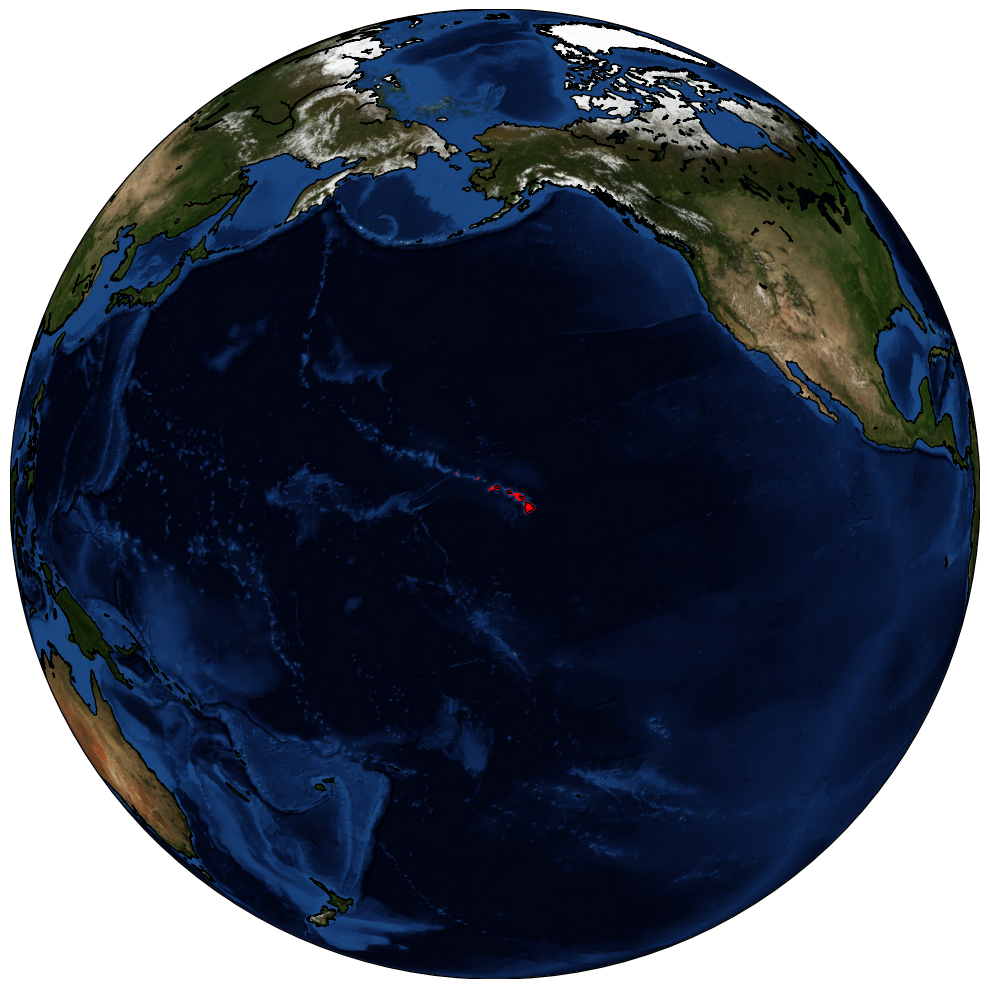

In [6]:
def show_area(area_shape, area_buffer=0.3):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="ortho", lat_0=lat, lon_0=lng, resolution="l")
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor="red", edgecolor="red"))

    plt.tight_layout()
    plt.show()


show_area(hawaii_area)

#### Area Splitting
We would like to request a larger area of very high resolution data, so we need to split the area into smaller bounding boxes to not exceed the [Process API](https://docs.sentinel-hub.com/api/latest/api/process/) size restriction of 2500 pixels in height and width. For larger requests, we recommend using the [Asynchronous Process API](https://docs.sentinel-hub.com/api/latest/api/async-process/) that supports up to 10,000 pixels in height and width.

The [large area utilities](https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html) offer several three different ways of splitting the area. Please find more details in the [documentation](https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.areas.html), and some more examples [here](https://sentinelhub-py.readthedocs.io/en/latest/examples/large_area_utilities.html).

##### Splitting the bounding box
The most straight forward approach is to calculate the area bounding box and split it into smaller parts of equal size.

As an input we need to provide a list of geometries, their CRS, and int or tuple specifying to how many parts bounding box will be split.

In [7]:
bbox_splitter = BBoxSplitter(
    [hawaii_area], CRS.WGS84, (5, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((-164.7060394287109, 18.909858703613395), (-154.80583190917963, 23.579721450805607)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-164.7060394287109, 22.412255764007554), (-162.72599792480466, 23.579721450805607)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-164.7060394287109, 18.909858703613395), (-154.80583190917963, 23.579721450805607)), crs=CRS('4326')), 'index_x': 0, 'index_y': 3}



Besides the list of bounding boxes it is also possible to get a list of geometries (i.e. intersection of each bounding box with entire area of interest).

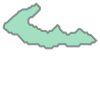

In [8]:
geometry_list = bbox_splitter.get_geometry_list()

geometry_list[0]

In order to visualize the splits let’s use the following function

In [9]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    base_map = Basemap(
        projection="mill",
        lat_0=lat,
        lon_0=lng,
        llcrnrlon=minx,
        llcrnrlat=miny,
        urcrnrlon=maxx,
        urcrnrlat=maxy,
        resolution="l",
        epsg=4326,
    )
    base_map.drawcoastlines(color=(0, 0, 0, 0))

    area_shape = splitter.get_area_shape()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red"))
        else:
            ax.add_patch(
                plt_polygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red")
            )

    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()

    cm = plt.get_cmap("jet", len(bbox_list))
    legend_shapes = []
    for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor="green"))

        if show_legend:
            legend_shapes.append(plt.Rectangle((0, 0), 1, 1, fc=cm(i)))

    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = "{},{}".format(info["index_x"], info["index_y"])

            for prop in ["grid_index", "tile"]:
                if prop in info:
                    legend_name = "{},{}".format(info[prop], legend_name)

            legend_names.append(legend_name)

        plt.legend(legend_shapes, legend_names)
    plt.tight_layout()
    plt.show()

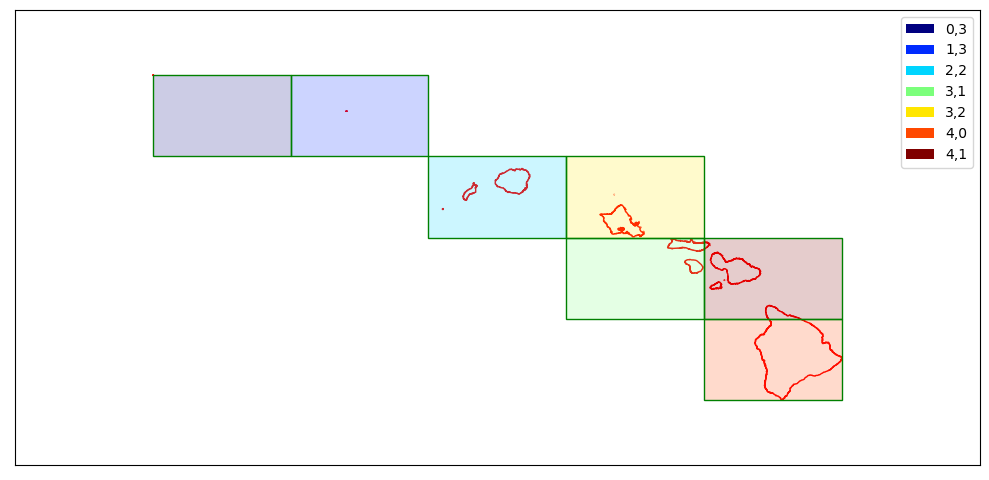

In [10]:
show_splitter(bbox_splitter, show_legend=True)

Splitter automatically removed the bounding boxes that did not intersect with the geometry of Hawaii Islands. However the majority of the area inside bounding boxes is still outside our geometry. Therefore each splitter has also an optional parameter reduce_bbox_sizes.

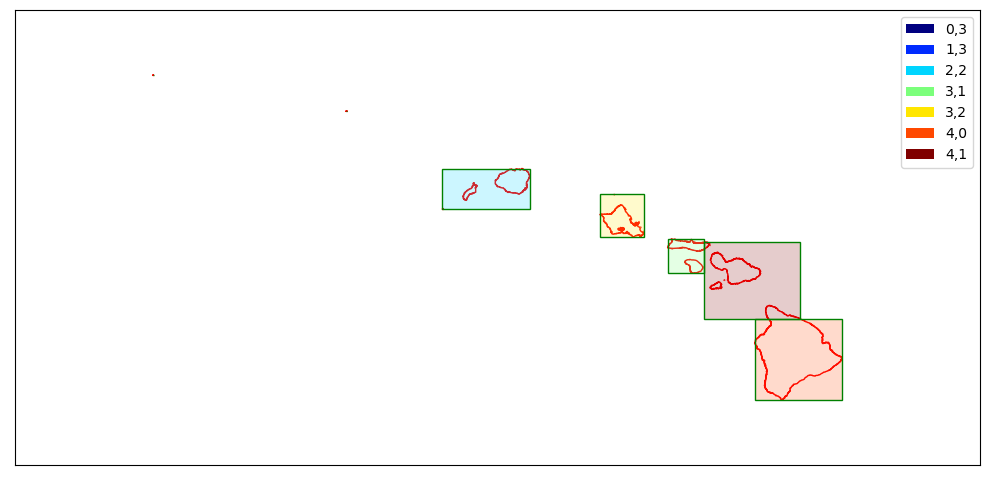

In [11]:
bbox_splitter_reduced = BBoxSplitter([hawaii_area], CRS.WGS84, (5, 4), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

By specifying finer splitting we could even further reduce the total area of bounding boxes.

#### Download data from the bounding boxes using sentinelhub-py
As we can see, with the large area utilities we can easily create the bounding boxes around the desired areas. Next we are going to get the data for "Kauai island (upper left), that is composed by 4 bounding boxes, to show how we can combine these utilities with the multithreaded download tools." (This will change)

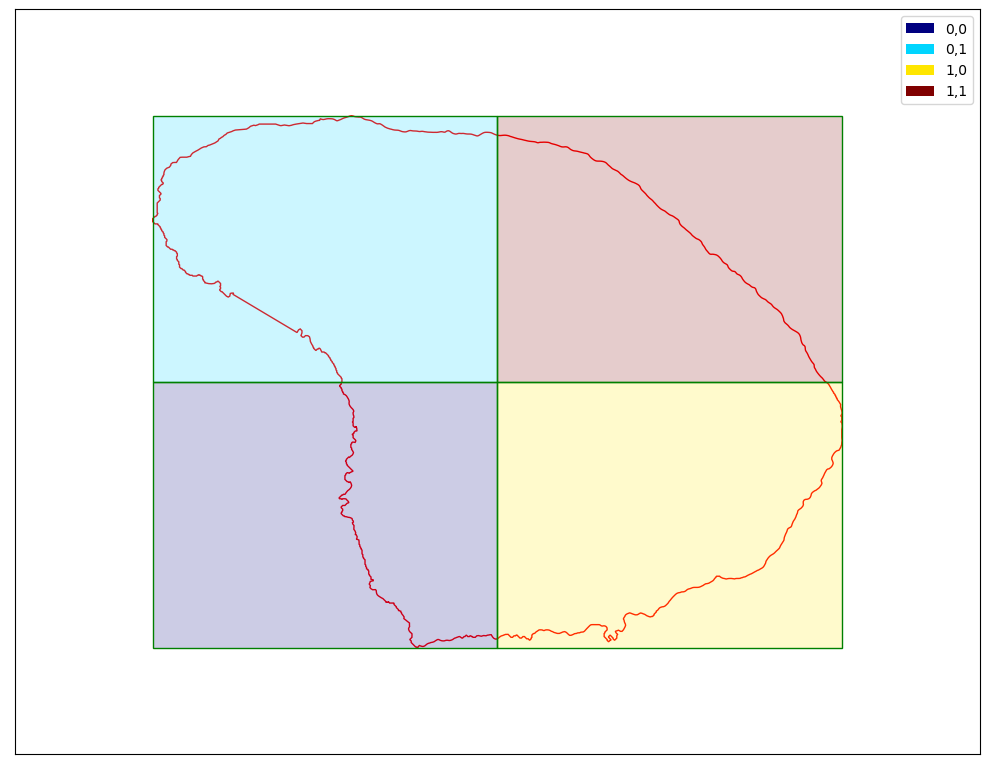

In [12]:
kauai = hawaii_area.geoms[5]
kauai_split = BBoxSplitter([kauai], CRS.WGS84, (2, 2))
show_splitter(kauai_split, show_legend=True)


We will use an NDVI evalscript to get example data.

In [13]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1
    }
  }
}
"""

This is a helper function which returns a SentinelHubRequest for a specified bounding box. This is then applied to all bounding boxes, thus returning a list of SentinelHubRequests each with a different specified bounding box.

We save the requested TIFF files in a temporary folder, but it can be specified to another location in case it is needed.

In [21]:
def get_subarea(bbox):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2020-10-01', '2022-10-13'),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=(1250, 1250),
        data_folder=r"./output/",
        config=config,
    )

In [22]:
# create a list of requests
bbox_list = kauai_split.get_bbox_list()
sh_requests = [get_subarea(bbox) for bbox in bbox_list]
sh_requests

Once we get the list of the requests for all the bounding boxes areas, we will download the data with the multithreaded tool.

In [23]:
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)

Once the data is downloaded, we retreive all paths to the downloaded tiles.

In [24]:
data_folder = sh_requests[0].data_folder
tiffs = [Path(data_folder) / req.get_filename_list()[0] for req in sh_requests]

Then opening all tiles with rioxarray we mosaic the full image and plot it. Be aware though that plotting might query a lot of data if there are many large tiles. This can be very slow and consume a lot of resources.

An alternative would be to combine the tiles using the GDAL command line function gdalbuildvrt and optionally building overviews using gdaladdo so that the data can be displayed quicker at different scales.

In [25]:
def plot_xr_and_bboxes(data_array, geo_vector=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_array.plot(ax=ax)
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set_aspect(1)
    if geo_vector is not None:
        geo_vector.plot(ax=ax, edgecolor="red", facecolor="none")
    plt.show()

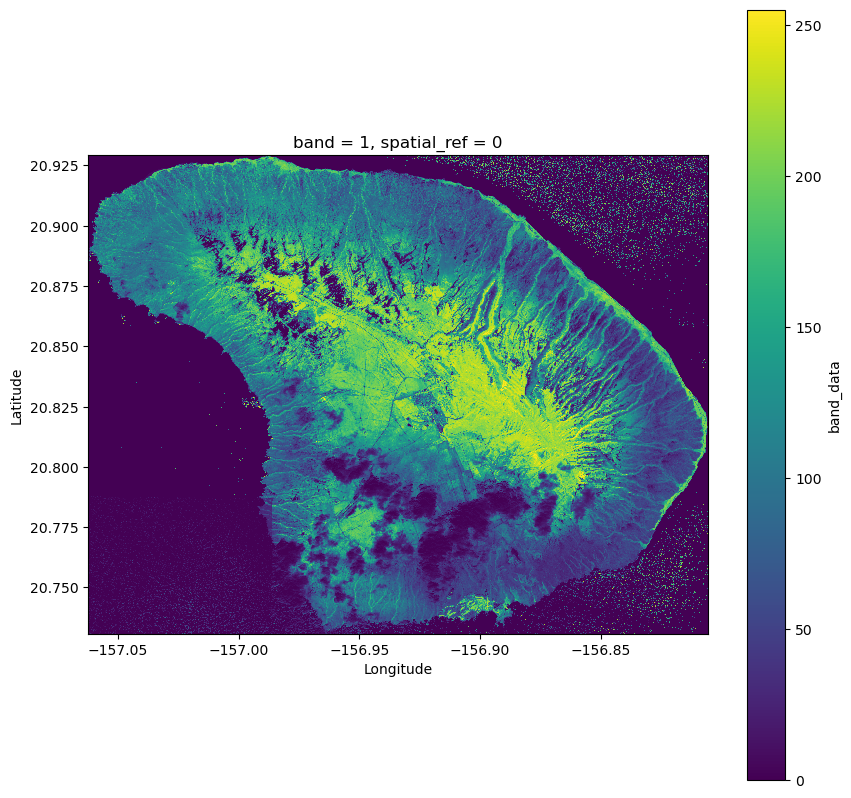

In [26]:
composed_tiff = xr.open_mfdataset(tiffs, engine="rasterio")
composed_map = composed_tiff.band_data.isel(band=0)

plot_xr_and_bboxes(composed_map)

Finally to visualize the bounding boxes as well we can draw the original bounding boxes over our raster.

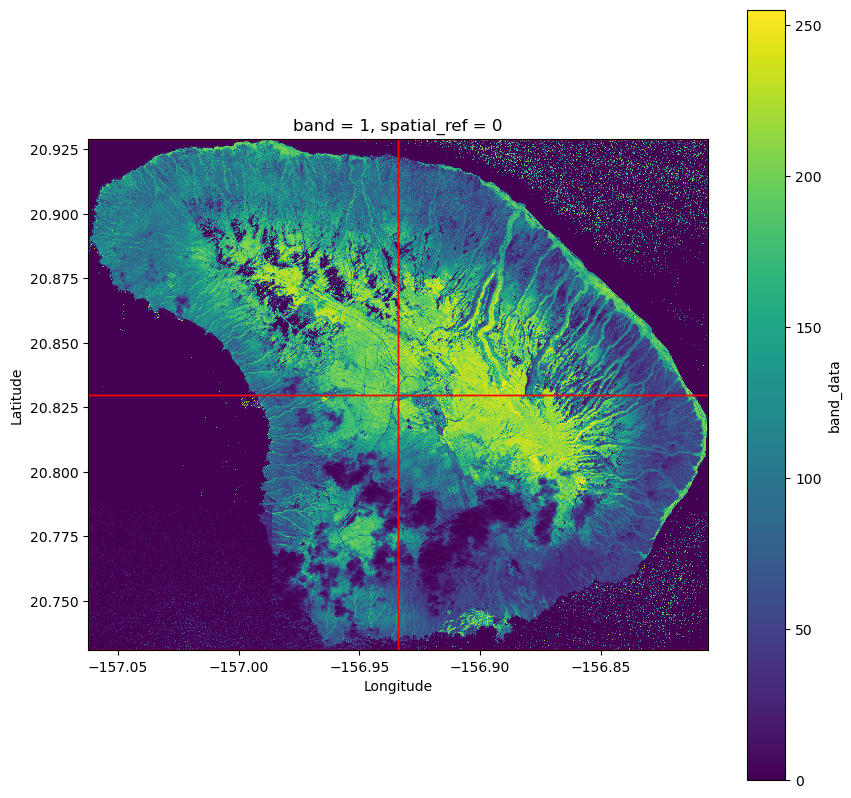

In [27]:
kauai_gpd = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bbox_list], crs=4326)
plot_xr_and_bboxes(composed_tiff.band_data, kauai_gpd)